# Fitbit sleep duration analysis
Created by Luke Kippenbrock and last edited on 22 Oct 2019

- Look for correlations between Fitbit sleep duration and other Fitbit parameters
- Perform linear regression analysis

## Import modules and set data directory

In [1]:
from collections import Counter, defaultdict
import csv
import datetime
import json
import math
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import pandas as pd
from scipy import stats
import statistics
from typing import Any, Dict, List, NamedTuple 

fitbit_directory_name = "LukeKippenbrock/user-site-export"
fitbit_directory = os.fsencode(fitbit_directory_name)

# Functions

## Create function to get activity data from Fitbit directory
Get Fitbit data and save the data to a csv file.  The saved csv file speeds ups analysis. If data has already been saved to file, the code simply loads the data from file.

In [2]:
def get_fitbit_data(parameter: str, name: str) -> pd.DataFrame:
    #Check first to see if processed data already exists
    if os.path.exists(f"Processed_Data/{parameter}.csv"):
        df_parameter = pd.read_csv(f"Processed_Data/{parameter}.csv",index_col=0)
        df_parameter.index = pd.to_datetime(df_parameter.index)
    #Otherwise process the data
    else:
        value_dict: Dict[str, float] = defaultdict(float) #Create dict to store date/value pair
        for file in os.listdir(fitbit_directory): #loop through all files in directory
            filename = os.fsdecode(file)
            log_name = parameter
            if "DEFAULT" in parameter:
                log_name = "time_in_heart_rate_zones"
            if log_name in filename: #Only open files for chosen parameter
                filename_with_directory = f"{fitbit_directory_name}/{filename}"
                with open(filename_with_directory,"r") as f:
                    data = f.read()
                    obj = json.loads(data)
                    for value_event in obj:
                        if log_name=="time_in_heart_rate_zones":
                            value = float(value_event["value"]["valuesInZones"][parameter])
                        else:
                            value = float(value_event["value"]) #get value for each value_event
                        string_dt = value_event["dateTime"] #get datetime for each value_event
                        dt = datetime.datetime.strptime(string_dt,'%m/%d/%y %H:%M:%S') #Convert to datetime format
                        #Steps and distance in file are dated according to GMT, which is 7 hours ahead of Seattle, so a shift is necessary
                        if parameter=="steps":
                            dt += datetime.timedelta(hours=-7)
                        if parameter=="distance":
                            dt += datetime.timedelta(hours=-7)
                        string_date = dt.strftime('%m/%d/%Y')
                        value_dict[string_date] += value
        #Save data to file
        df_parameter = pd.DataFrame.from_dict(value_dict, orient='index',columns=[name])
        df_parameter.index = pd.to_datetime(df_parameter.index)
        df_parameter = df_parameter.sort_index()
        df_parameter.to_csv(f"Processed_Data/{parameter}.csv")
    #Add parameter to the pandas dataframe
    return df_parameter

## Create function to extract Seattle weather data from csv file
Record the min and max temperature for each date

In [3]:
def get_weather_data() -> pd.DataFrame:
    temp_max_list = []
    temp_min_list = []
    date_list = []
    with open('SeattleWeather.csv') as f:
        comma_reader = csv.reader(f, delimiter=',')
        next(comma_reader) #skip the first row of the file (header row)
        for row in comma_reader:
            string_date = row[2]
            #converted_date = datetime.datetime.strptime(string_date, '%Y-%m-%d').date()
            temp_max = float(row[4])
            temp_min = float(row[5])
            temp_max_list.append(temp_max)
            temp_min_list.append(temp_min)
            date_list.append(string_date)

    df_weather = pd.DataFrame({"temperature max":temp_max_list,
                               "temperature min":temp_min_list},
                                index=date_list)
    df_weather.index = pd.to_datetime(df_weather.index)
    return df_weather

## Create function to get raw Fitbit sleep data
Sleep data for each sleep event is saved to a dataframe.

In [4]:
def get_sleep_data() -> pd.DataFrame:
    start_time_list = []
    stop_time_list = []
    duration_list = []
    wake_list = []
    light_list = []
    rem_list = []
    deep_list = []
    for file in os.listdir(fitbit_directory):
        filename = os.fsdecode(file)
        if "sleep" in filename:
            filename_with_directory = f"{fitbit_directory_name}/{filename}"
            with open(filename_with_directory,"r") as f:
                data = f.read()
                obj = json.loads(data)
                for sleep_event in obj:
                    #if (sleep_event["type"] != "stages"): continue
                    duration_list.append(sleep_event["minutesAsleep"]/60) #Get hours asleep
                    wake = np.nan
                    light = np.nan
                    rem = np.nan
                    deep = np.nan
                    summary = sleep_event["levels"]["summary"]
                    if "wake" in summary:
                        wake = summary["wake"]["minutes"]/60
                    if "light" in summary:
                        light = summary["light"]["minutes"]/60
                    if "rem" in summary:
                        rem = summary["rem"]["minutes"]/60
                    if "deep" in summary:
                        deep = summary["deep"]["minutes"]/60
                    wake_list.append(wake)
                    light_list.append(light)
                    rem_list.append(rem)
                    deep_list.append(deep)
                    string_start_time = sleep_event["startTime"] #Get date in string format
                    string_stop_time = sleep_event["endTime"] #Get date in string format
                    start_time = datetime.datetime.strptime(string_start_time,'%Y-%m-%dT%H:%M:%S.000') #Convert to datetime format
                    stop_time = datetime.datetime.strptime(string_stop_time,'%Y-%m-%dT%H:%M:%S.000') #Convert to datetime format
                    start_time_list.append(start_time)
                    stop_time_list.append(stop_time)
    #Save the data in a dataframe
    df_sleep = pd.DataFrame({"stop time":stop_time_list,
                             "duration":duration_list,
                             "wake sleep":wake_list,
                             "light sleep":light_list,
                             "rem sleep":rem_list,
                             "deep sleep":deep_list},
                            index=start_time_list)
    df_sleep = df_sleep.sort_index() #Sort by start time
    df_sleep = df_sleep.drop_duplicates() #Remove duplicate sleep events (happens at beginning/end of each file)
    return df_sleep

## Create function to process raw sleep data

Several things are done in this code:
- Exclude sleep events that occur when I'm not in Seattle
- Remove naps (events which start between noon and 8pm and which end before 8pm)
- Combine sleep events that occur during the same night

In [5]:
def process_sleep_data(df_sleep_raw: pd.DataFrame) -> pd.DataFrame:
    date_list = []
    duration_list = []
    wake_list = []
    light_list = []
    rem_list = []
    deep_list = []
    start_time_plotting_list = []
    stop_time_plotting_list = []
    sleep_segment_list = []
    previous_date = datetime.date(2000, 8, 30)  #random date in the far past

    #Exclude dates when I was not in Seattle
    #travel_dates is a list of dates in the format
    #travel_dates = [[datetime.date(2016, 12, 20), datetime.date(2017, 1, 4)],...
    from vacation_dates import travel_dates

    #Record all sleep events on the same date (for plotting purposes)
    default_datetime = datetime.datetime(2000, 1, 1, 0, 0, 0);

    for index, row in df_sleep_raw.iterrows():
        start = index
        stop = row['stop time']
        duration = row['duration']
        wake = row['wake sleep']
        light = row['light sleep']
        rem = row['rem sleep']
        deep = row['deep sleep']
        #Get start hour of sleep event
        start_hour = start.hour
        #Shift date to prior day for start times after midnight til 11am
        if start_hour<11:
            date = start.date() - datetime.timedelta(days=1)
            shift = datetime.timedelta(hours=0)
        #But don't shift date when sleep starts after 11am and before midnight
        else:
            date = start.date()
            shift = datetime.timedelta(hours=-24)
        seattle_date = True
        #Exlude days when not in Seattle
        for date_range in travel_dates:
            travel_start, travel_stop = date_range
            if travel_start <= date <= travel_stop:
                seattle_date = False
                break
        if seattle_date:
            #Remove naps
            if 12<=start.hour<20 and stop.hour<20:
                continue
            #Combine sleep records for events with same dates
            elif previous_date==date:
                sleep_segment_list[-1] += 1 
                duration_list[-1] += duration
                wake_list[-1] += wake
                light_list[-1] += light
                rem_list[-1] += rem
                deep_list[-1] += deep
                stop_timedelta = datetime.timedelta(hours=stop.hour,minutes=stop.minute,seconds=stop.second)
                stop_time_plotting_list[-1] = default_datetime + stop_timedelta
            #Save sleep record
            else:
                sleep_segment_list.append(1)
                date_list.append(date)
                duration_list.append(duration)
                wake_list.append(wake)
                light_list.append(light)
                rem_list.append(rem)
                deep_list.append(deep)
                start_timedelta = datetime.timedelta(hours=start.hour,minutes=start.minute,seconds=start.second)
                start_time_plotting_list.append(default_datetime + start_timedelta + shift)
                stop_timedelta = datetime.timedelta(hours=stop.hour,minutes=stop.minute,seconds=stop.second)
                stop_time_plotting_list.append(default_datetime + stop_timedelta)
            previous_date = date

    #Convert list of datetime objects to list of "seconds" objects
    start_time_list = []
    stop_time_list = []
    for x,y in zip(start_time_plotting_list,stop_time_plotting_list):
        start_delta = x - default_datetime
        start_time_list.append(start_delta.total_seconds())
        stop_delta = y - default_datetime
        stop_time_list.append(stop_delta.total_seconds())
    
    for x in range(len(duration_list)):
        duration = duration_list[x]
        wake_list[x] *= 1/duration
        light_list[x] *= 1/duration
        rem_list[x] *= 1/duration
        deep_list[x] *= 1/duration
    #Save the data in a dataframe
    df_sleep_clean = pd.DataFrame({"start time plotting":start_time_plotting_list,
                                   "stop time plotting":stop_time_plotting_list,
                                   "sleep start time":start_time_list,
                                   "sleep stop time":stop_time_list,
                                   "sleep duration":duration_list,
                                   "wake sleep fraction":wake_list,
                                   "light sleep fraction":light_list,
                                   "rem sleep fraction":rem_list,
                                   "deep sleep fraction":deep_list,
                                   "sleep segments":sleep_segment_list},
                                index=date_list)
    df_sleep_clean.index = pd.to_datetime(df_sleep_clean.index)
    return df_sleep_clean

# Analysis

## Get the data

In [6]:
#Create a pandas dataframe to store Fitbit data
dates = pd.date_range(start='1/2/2017', end='8/31/2019') #Dates spanned by Fitbit data
df = pd.DataFrame(index=dates)
df['weekday'] = df.index.weekday #Set column for date weekday, see Ref #5
df['month'] = df.index.month #Set column for date month

#List of fitbit activity parameters of interest
fitbit_list = [["distance","distance"],
               ["calories","calories"],
               ["altitude","altitude"],
               ["lightly_active","time lightly active"],
               ["moderately_active","time moderately active"],
               ["very_active","time very active"],
               ["sedentary","time sedentary"],
               ["BELOW_DEFAULT_ZONE_1","heart rate zone 0"],
               ["IN_DEFAULT_ZONE_1","heart rate zone 1"],
               ["IN_DEFAULT_ZONE_2","heart rate zone 2"],
               ["IN_DEFAULT_ZONE_3","heart rate zone 3"]]

#Get fitbit data for each parameter and store in a dataframe
for parameter, name in fitbit_list:
    df_parameter = get_fitbit_data(parameter, name)
    df[name] = df_parameter

#Get weather data and store in a dataframe
df_weather = get_weather_data()
df = df.join(df_weather)

#Get fitbit sleep data (raw), process it, and then join it to the main dataframe
df_sleep_raw = get_sleep_data()
df_sleep = process_sleep_data(df_sleep_raw)
df = df.join(df_sleep)

## Sleep duration plotted as a function of time

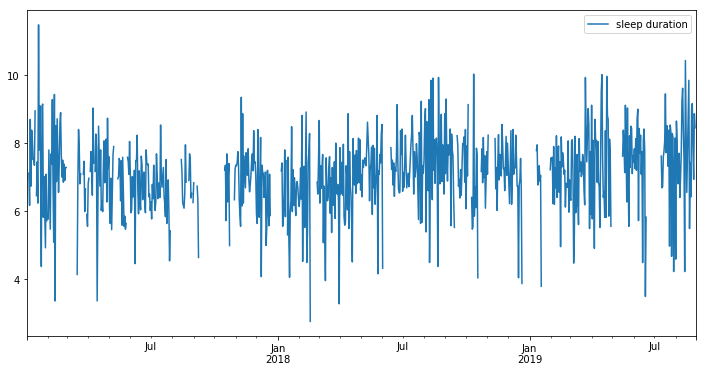

In [7]:
sleep_time_data = pd.DataFrame(df['sleep duration'], df.index, columns=["sleep duration"])
sleep_time_data.plot(figsize=(12, 6))

## Sleep fraction plotted as a function of time

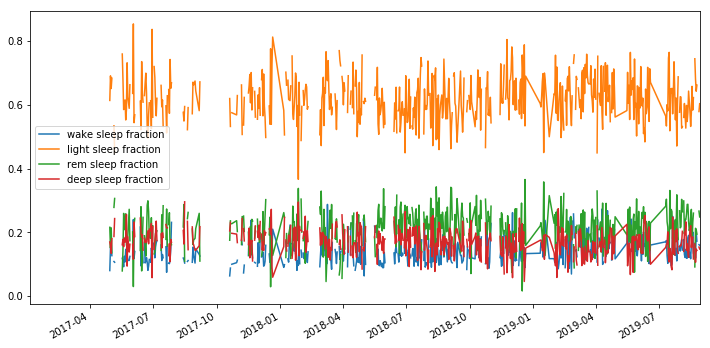

In [8]:
columns = ['wake sleep fraction',
           'light sleep fraction',
           'rem sleep fraction',
           'deep sleep fraction']
df_fraction = df_sleep[columns]
fraction_time_data = pd.DataFrame(df_fraction, df_sleep.index, columns=columns)
fraction_time_data.plot(figsize=(12, 6))

## Correlation matrix
Code based on example provided on seaborn website

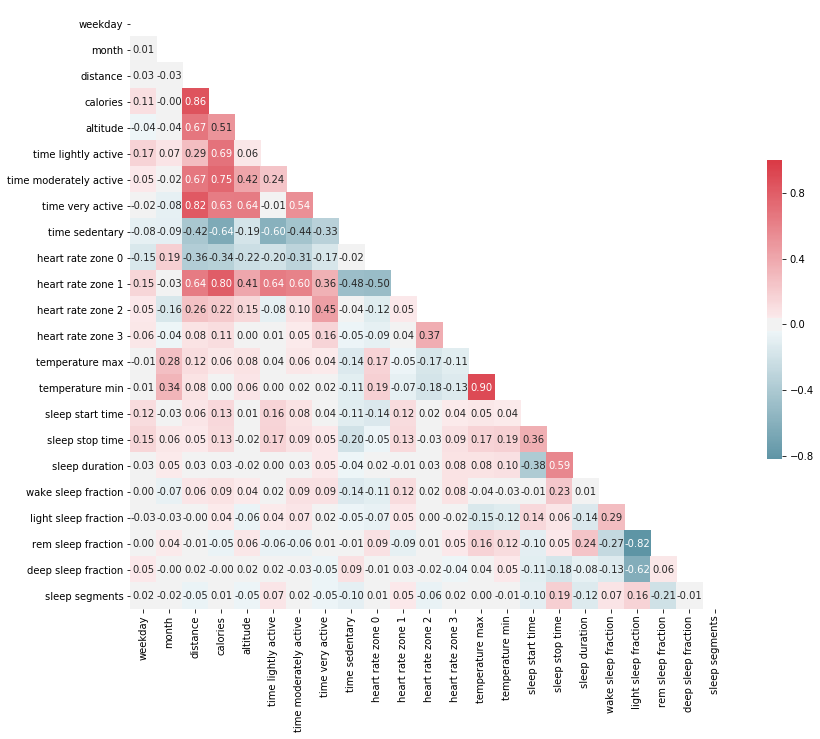

In [9]:
import seaborn as sns

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .5})
plt.show()


## Split data into training/test sets

In [49]:
from sklearn.model_selection import train_test_split

#Create new pandas dataframe that removes troublesome rows and columns
df_lr = df
df_lr = df_lr.drop('wake sleep fraction',axis='columns')
df_lr = df_lr.drop('light sleep fraction',axis='columns')
df_lr = df_lr.drop('rem sleep fraction',axis='columns')
df_lr = df_lr.drop('deep sleep fraction',axis='columns')
df_lr = df_lr.drop('start time plotting',axis='columns')
df_lr = df_lr.drop('stop time plotting',axis='columns')
df_lr = df_lr.reset_index() #Remove date column
df_lr = df_lr.drop('index',axis='columns') 
df_lr = df_lr.dropna(how='any') #Remove rows that contain any NA
y = df_lr['sleep duration']
df_lr = df_lr.drop('sleep duration',axis='columns')
X = df_lr

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)
#print(X_train.shape)
#print(X_test.shape)

## Linear regression
Code based on example given in [Ref #3](#References)

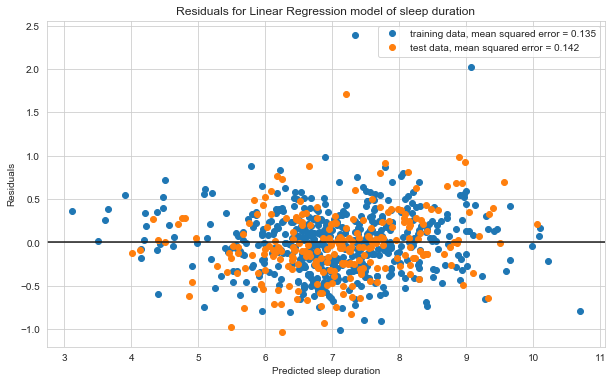

In [59]:
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso
from sklearn.feature_selection import f_regression

lm = LinearRegression()
#lm = Ridge(alpha=.5)
#lm = Lasso(alpha=.1)
lm.fit(X_train, y_train)
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

MSE_train = np.mean((y_train - pred_train)**2)
MSE_test = np.mean((y_test - pred_test)**2)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
plt.plot(pred_train, pred_train - y_train, 'o', label='training data, mean squared error = {0:.3f}'.format(MSE_train))
plt.plot(pred_test, pred_test - y_test, 'o', label='test data, mean squared error = {0:.3f}'.format(MSE_test))
ax.axhline(y=0, color='k')
plt.legend()
plt.title('Residuals for Linear Regression model of sleep duration')
plt.xlabel('Predicted sleep duration')
plt.ylabel('Residuals')
plt.show()

f_values, p_values = f_regression(X, y)

## Feature Importance

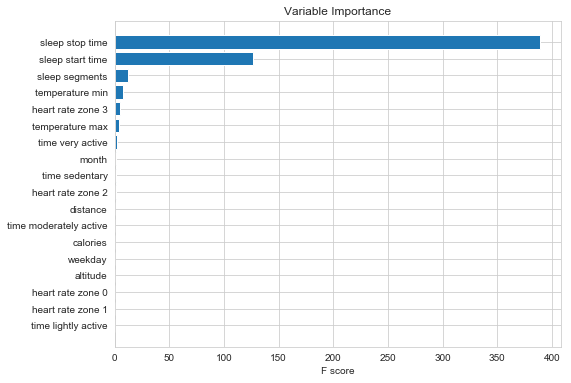

In [48]:
# Plot feature importance
plt.figure(figsize=(8, 6))
feature_importance = f_values
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('F score')
plt.title('Variable Importance')
plt.show()

## Random forest regression

testing data MSE: 0.3472


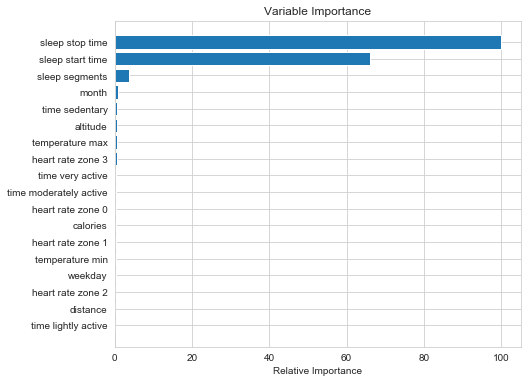

In [44]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=4, random_state=0,
                             n_estimators=100)
regr.fit(X_train, y_train) 


mse = mean_squared_error(y_test, regr.predict(X_test))
print("testing data MSE: %.4f" % mse)

# Plot feature importance
plt.figure(figsize=(16, 6))
feature_importance = regr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Gradient Boosting regression
This code is taken from [Ref #4](#References) with small modifications.

MSE: 0.2003


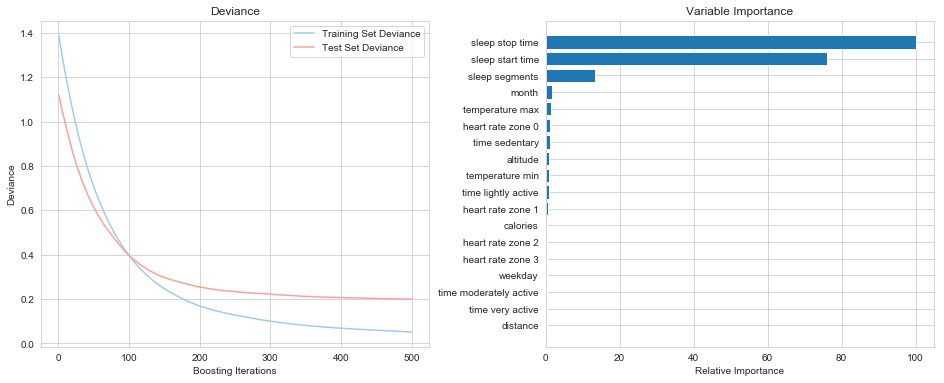

In [21]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace = 0.3)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Plotting data

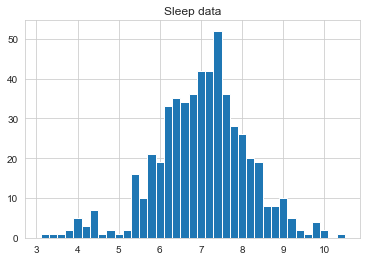

In [75]:
#Functions taken from "Data Science from Scratch", second edition, by Joel Grus
def bucketize(point: float, bucket_size: float) -> float:
    """Floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """Buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()
    plt.close()

df_clean = df.dropna(how='any')
sleep_list = df_clean['sleep duration'].tolist()
plot_histogram(sleep_list,0.2,"Sleep data")

## Average sleep duration by weekday, month

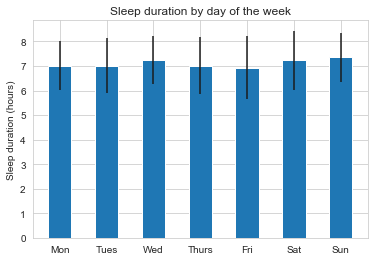

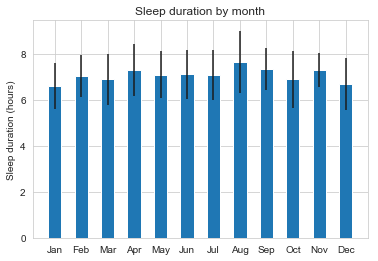

In [76]:
def plot_variable_histogram(sleep_list: List[float], variable_list: List[float], setting: str):
    mean_list = []
    stdev_list = []
    start = 0
    stop = 7
    if setting=="month":
        start = 1
        stop = 13
    for x in range(start,stop):
        variable_sleep_list = []
        for sleep, variable in zip(sleep_list, variable_list):
            if variable==x:
                variable_sleep_list.append(sleep)
        #print(f"{x} {variable_sleep_list}")
        mean = statistics.mean(variable_sleep_list)
        mean_list.append(mean)
        stdev = statistics.stdev(variable_sleep_list)
        stdev_list.append(stdev)
    #plot_histogram(variable_sleep_list,0.5,f"Day = {x}")
    #Plot sleep duration by weekday (See Ref #2)
    if setting=="weekday":
        N = 7
        ind = np.arange(N)    # the x locations for the groups
        width = 0.50       # the width of the bars: can also be len(x) sequence
        p1 = plt.bar(ind, mean_list, width, yerr=stdev_list)
        plt.ylabel('Sleep duration (hours)')
        plt.title('Sleep duration by day of the week')
        plt.xticks(ind, ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri','Sat','Sun'))
        plt.show()
        plt.close()
    elif setting=="month":
        N = 12
        ind = np.arange(N)    # the x locations for the groups
        width = 0.50       # the width of the bars: can also be len(x) sequence
        p1 = plt.bar(ind, mean_list, width, yerr=stdev_list)
        plt.ylabel('Sleep duration (hours)')
        plt.title('Sleep duration by month')
        plt.xticks(ind, ('Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
        plt.show()
        plt.close()

weekday_list = df_clean['weekday'].tolist()
month_list = df_clean['month'].tolist()
plot_variable_histogram(sleep_list, weekday_list, "weekday")
plot_variable_histogram(sleep_list, month_list, "month")

## Plot sleep duration as a function of other parameters
Look for correlations between sleep duration and the parameters

In [72]:
def plot_nice(list1: List[Any], list2: List[Any], title: str, label1: str, label2: str):
    plt.plot(list1, list2, 'o', alpha=0.2, label='data')
    # label each point
    '''for x, y, date in zip(list1, list2, date_list):
        plt.annotate(date,
                 xy=(x, y), # Put the label with its point
                 xytext=(5, -5),                  # but slightly offset
                 textcoords='offset points',
                 size=5)'''
    plt.title(title)
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    x = np.asarray(list1)
    y = np.asarray(list2)

    if isinstance(list1[0],datetime.datetime): #For time on x-axis (see Ref #1)
        x = dates.date2num(list1)
        plt.gcf().autofmt_xdate()
        myFmt = dates.DateFormatter('%H:%M')
        plt.gca().xaxis.set_major_formatter(myFmt)
    if isinstance(list2[0],datetime.datetime): #For time on y-axis
        y = dates.date2num(list2)
        myFmt = dates.DateFormatter('%H:%M')
        plt.gca().yaxis.set_major_formatter(myFmt)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    #print("slope: %f    intercept: %f" % (slope, intercept))
    print(f"correlation: {r_value} for {title}")
    plt.plot(x, intercept + slope*x, 'r', label='linear fit')
    plt.legend()
    
    ax = plt.gcf().axes[0]
    ax.grid(True)
    #if (r_value**2 >0.05):
    plt.show()
    plt.gca().clear()
    plt.close()

#plot_nice(heart_below_one_list,sleep_list,"Sleep duration vs. Time below heart zone 1","Time below heart zone 1 (hours)","Sleep duration (hours)")
#plot_nice(heart_zone_one_list,sleep_list,"Sleep duration vs. Time in heart zone 1","Time in heart zone 1 (hours)","Sleep duration (hours)")
#plot_nice(heart_zone_two_list,sleep_list,"Sleep duration vs. Time in heart zone 2","Time in heart zone 2 (minutes)","Sleep duration (hours)")
#plot_nice(heart_zone_three_list,sleep_list,"Sleep duration vs. Time in heart zone 3","Time in heart zone 3 (minutes)","Sleep duration (hours)")

#plot_nice(lightly_active_list,sleep_list,"Sleep duration vs. Lightly active time","Lightly active time (hours)","Sleep duration (hours)")
#plot_nice(moderately_active_list,sleep_list,"Sleep duration vs. Moderately active time","Moderately active time (hours)","Sleep duration (hours)")
#plot_nice(very_active_list,sleep_list,"Sleep duration vs. Very active time","Very active time(hours)","Sleep duration (hours)")
#plot_nice(sedentary_list,sleep_list,"Sleep duration vs. Sedentary time","Sedentary time (hours)","Sleep duration (hours)")

#plot_nice(stairs_list,sleep_list,"Sleep duration vs. Floors","Floors","Sleep duration (hours)")
#plot_nice(distance_list,sleep_list,"Sleep duration vs. Distance","Distance (miles)","Sleep duration (hours)")
#plot_nice(calories_list,sleep_list,"Sleep duration vs. Calories","Calories","Sleep duration (hours)")
#plot_nice(steps_list,sleep_list,"Sleep duration vs. Steps","Steps","Sleep duration (hours)")

#plot_nice(temp_max_list,sleep_list,"Sleep duration vs. Max temperature","Max temperature ($^\circ$F)","Sleep duration (hours)")
#plot_nice(temp_min_list,sleep_list,"Sleep duration vs. Min temperature","Min temperature ($^\circ$F)","Sleep duration (hours)")

#plot_nice(previous_day_sleep_list,current_day_sleep_list,"Sleep duration vs. Previous day's sleep","Previous day's sleep (hours)","Sleep duration (hours)")

correlation: -0.39028534606069976 for Sleep duration vs. Start time


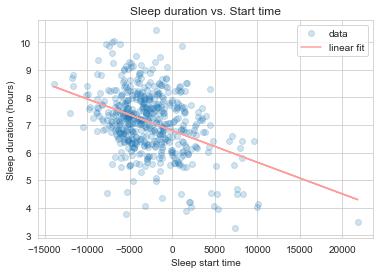

correlation: 0.6366524415396336 for Sleep duration vs. Stop time


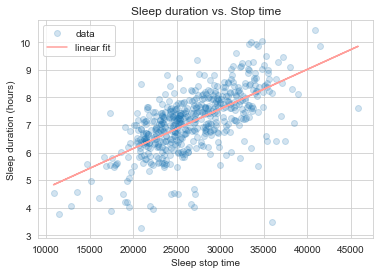

In [73]:
sleep_list = df_clean['sleep duration'].tolist()
start_time_list = df_clean['sleep start time'].tolist()
stop_time_list = df_clean['sleep stop time'].tolist()
plot_nice(start_time_list,sleep_list,"Sleep duration vs. Start time","Sleep start time","Sleep duration (hours)")
plot_nice(stop_time_list,sleep_list,"Sleep duration vs. Stop time","Sleep stop time","Sleep duration (hours)")

## References 
Ref #1 = https://stackoverflow.com/questions/1574088/plotting-time-in-python-with-matplotlib/16428019#16428019

Ref #2 = https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html#sphx-glr-gallery-lines-bars-and-markers-bar-stacked-py

Ref #3 = https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/

Ref #4 = https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

Ref #5 = https://stackoverflow.com/questions/40815238/python-pandas-convert-index-to-datetime
